Avaliação Prática: Regressão Linear e Diagnóstico Estatístico

Aluno: Gustavo Gomes Holanda -----
Matrícula: 2214634

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

In [172]:
df = pd.read_csv("dataset_10.csv")

Parte I – Análise Estatística

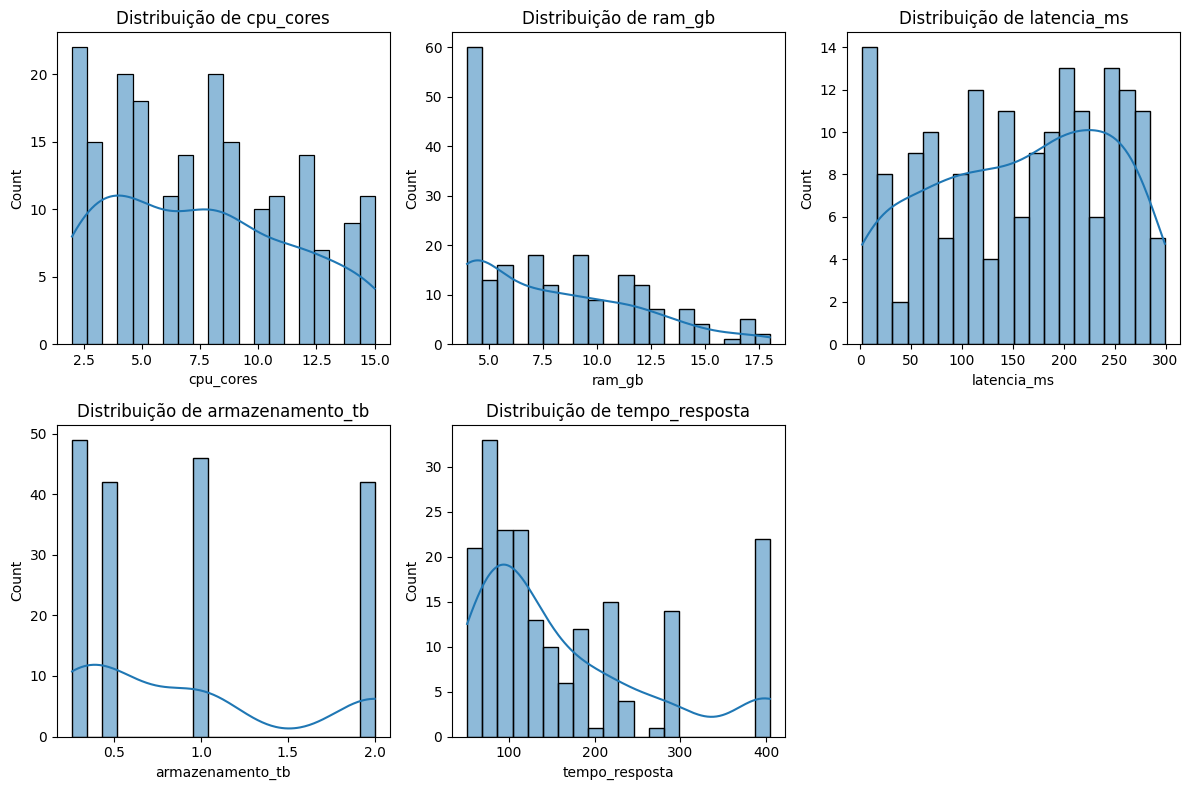

                  count        mean         std     min     25%      50%  \
cpu_cores         197.0    7.558376    3.967070   2.000   4.000    7.000   
ram_gb            198.0    7.873737    3.783375   4.000   4.000    7.000   
latencia_ms       179.0  156.524972   87.525782   2.010  86.230  166.460   
armazenamento_tb  179.0    0.916469    0.661444   0.256   0.256    0.512   
tempo_resposta    198.0  163.853636  105.275320  51.140  81.965  120.145   

                      75%     max  missing  
cpu_cores          11.000   15.00        1  
ram_gb             11.000   18.00        0  
latencia_ms       230.235  299.37       19  
armazenamento_tb    1.000    2.00       19  
tempo_resposta    222.080  404.27        0  


In [173]:
numerical_cols = ['cpu_cores', 'ram_gb', 'latencia_ms', 'armazenamento_tb', 'tempo_resposta']

stats = df[numerical_cols].describe().T
stats["missing"] = df[numerical_cols].isnull().sum() #Valores NaN

plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.tight_layout()
plt.show()

print(stats)

Parte II – Modelo e Diagnóstico

In [ ]:
# Mostrar os valores ausentes antes
print("Valores ausentes antes do tratamento:")
print(df.isnull().sum())

# Substituir valores ausentes apenas nas variáveis numéricas pela mediana
for coluna in numerical_cols:
    if df[coluna].isnull().sum() > 0:
        mediana = df[coluna].median()
        df[coluna] = df[coluna].fillna(mediana)
print("\nValores ausentes depois do tratamento:")
print(df.isnull().sum())
# Remover linhas onde tipo_hd é nulo
df = df.dropna(subset=['tipo_hd'])


Valores ausentes antes do tratamento:
cpu_cores               1
ram_gb                  0
latencia_ms            19
armazenamento_tb       19
sistema_operacional     0
tipo_hd                19
tipo_processador        0
tempo_resposta          0
dtype: int64

Valores ausentes depois do tratamento:
cpu_cores               0
ram_gb                  0
latencia_ms             0
armazenamento_tb        0
sistema_operacional     0
tipo_hd                19
tipo_processador        0
tempo_resposta          0
dtype: int64


In [ ]:
# Gera dummies para variáveis categóricas
df = pd.get_dummies(df, columns=['sistema_operacional', 'tipo_hd', 'tipo_processador'], drop_first=True, dtype=int)
print(df.head())


   cpu_cores  ram_gb  latencia_ms  armazenamento_tb  tempo_resposta  \
0       14.0      12       122.72             0.512           63.73   
2        5.0       6       107.49             0.512          176.34   
3       15.0      17       289.17             1.000           68.93   
4       12.0      11       280.91             2.000           79.21   
5        8.0       8       254.56             0.512          110.67   

   sistema_operacional_MacOS  sistema_operacional_Windows  tipo_hd_SSD  \
0                          1                            0            1   
2                          0                            0            0   
3                          1                            0            0   
4                          1                            0            1   
5                          0                            1            0   

   tipo_processador_Apple Silicon  tipo_processador_Intel  
0                               1                       0  
2       

In [ ]:
# Definir variável dependente (target)
y = df['tempo_resposta']

# Definir variáveis independentes (features)
X = df.drop(columns=['tempo_resposta'])

X = sm.add_constant(X)

In [ ]:
# Remover 'tipo_processador_Apple Silicon' de X por motivos que estava dando 'inf' pois existe multicolinearidade perfeita com macOS
X = X.drop(columns=['tipo_processador_Apple Silicon'])

model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     85.44
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.55e-55
Time:                        15:32:04   Log-Likelihood:                -942.39
No. Observations:                 179   AIC:                             1903.
Df Residuals:                     170   BIC:                             1931.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [178]:
# Calcular VIF para cada variável
vif_data = pd.DataFrame()
vif_data['Variável'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


                      Variável        VIF
0                        const  13.795218
1                    cpu_cores   9.506407
2                       ram_gb   9.550870
3                  latencia_ms   1.018513
4             armazenamento_tb   1.036096
5    sistema_operacional_MacOS   1.712352
6  sistema_operacional_Windows   1.379399
7                  tipo_hd_SSD   1.032656
8       tipo_processador_Intel   1.339888


In [ ]:
# Realizar o teste de Breusch-Pagan
_, pval, __, f_pval = het_breuschpagan(model.resid, model.model.exog)

print(f"P-valor do teste de Breusch-Pagan: {pval}")
if pval < 0.05:
    print("Existe evidência de heterocedasticidade (variância dos resíduos não é constante).")
else:
    print("Não há evidência de heterocedasticidade (variância constante).")

P-valor do teste de Breusch-Pagan: 3.161546116062918e-08
Existe evidência de heterocedasticidade (variância dos resíduos não é constante).


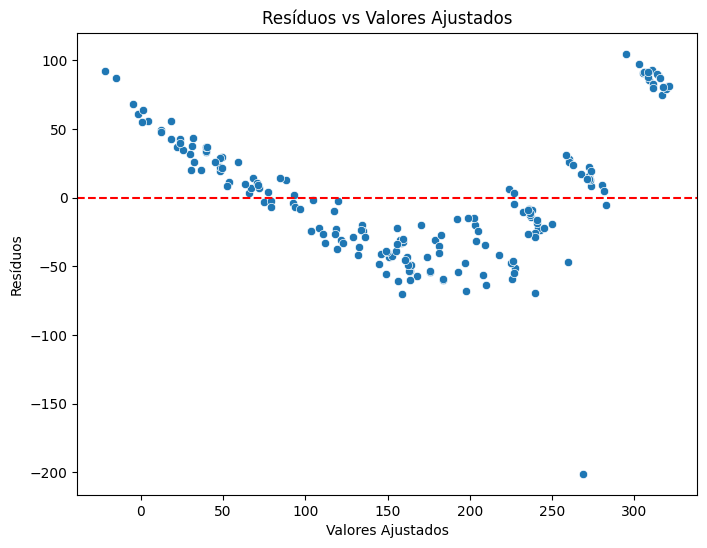

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.show()

Parte III – Análise Crítica

In [181]:
# Copiar X para evitar alterar o original
X_reduced = X.drop(columns=['latencia_ms'])

# Ajustar o modelo reduzido
model_reduced = sm.OLS(y, X_reduced).fit()

# Mostrar o resumo do modelo reduzido
print(model_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:         tempo_resposta   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     98.19
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.53e-56
Time:                        15:32:04   Log-Likelihood:                -942.41
No. Observations:                 179   AIC:                             1901.
Df Residuals:                     171   BIC:                             1926.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             